In [1]:
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Input, TimeDistributed, Bidirectional
from keras.losses import Huber, MeanSquaredError
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
plt.style.use('fivethirtyeight')

In [ ]:
#IHSG
stock_code = 'IHSG'
startdate = '2016-04-12'
enddate = '2021-04-12'
df = web.DataReader(f'^JKSE', data_source='yahoo', start = startdate, end = enddate)

Extract stock price data from Yahoo Finance

In [2]:
#Get Stock Price Data
stock_code = 'INCO'
#startdate = str((date.today()-timedelta(days = 365))) 
startdate = str((date.today()-relativedelta(years=5))) 
enddate = str(date.today())
df = web.DataReader(f'{stock_code}.JK', data_source='yahoo', start = startdate, end = enddate)

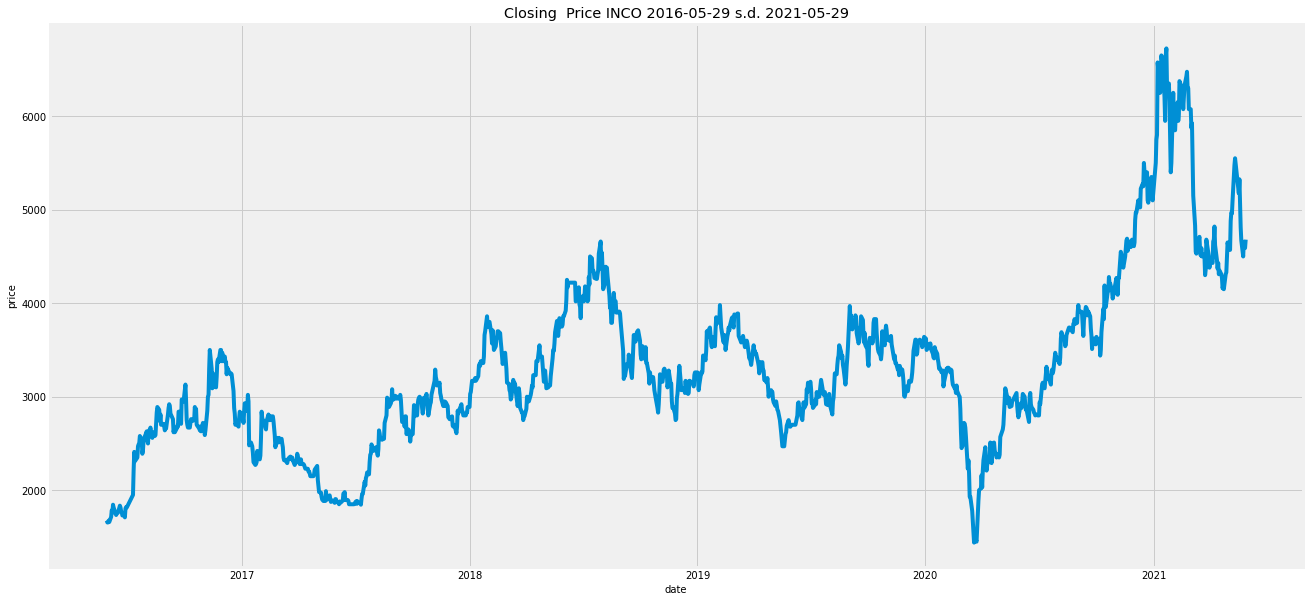

In [3]:
plt.figure(figsize=(20,10))
plt.title(f'Closing  Price {stock_code} {startdate} s.d. {enddate}')
#plt.plot(df['Open'])
plt.plot(df['Close'])
plt.xlabel('date', fontsize = 10)
plt.ylabel('price', fontsize = 10)
plt.show()

In [4]:
#Filter the dataframe, only take close price
data = df.filter(['Close'])
data["log_returns"] = np.log(1 + data['Close'].pct_change())
data.dropna(inplace=True)
dataset = data.values
data_len = len(dataset)
n_feature = dataset.shape[1]
print(data_len)

1257


In [ ]:
#embedding = LocallyLinearEmbedding(n_components=1)
#embedded_data = embedding.fit_transform(dataset)
#embedded_data.shape

MinMaxScaler scaled the data into range 0 to 1.

In [5]:
#Apply MinMaxScaler / Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
h = 360 #Test size
inp = 14 #Input size (days)

In [7]:
data.iloc[0:data_len-h-inp,:]

,Close,log_returns
Date,,
2016-05-31,1655.0,-0.012012
2016-06-01,1655.0,0.000000
2016-06-02,1675.0,0.012012
2016-06-03,1660.0,-0.008996
2016-06-06,1715.0,0.032595
...,...,...
2019-11-04,3600.0,-0.002774
2019-11-05,3640.0,0.011050
2019-11-06,3610.0,-0.008276


In [8]:
data.iloc[data_len-(inp+h):data_len,:]

,Close,log_returns
Date,,
2019-11-11,3440.0,-0.034289
2019-11-12,3400.0,-0.011696
2019-11-13,3440.0,0.011696
2019-11-14,3360.0,-0.023530
2019-11-15,3360.0,0.000000
...,...,...
2021-05-21,4670.0,-0.029538
2021-05-24,4500.0,-0.037082
2021-05-25,4650.0,0.032790


In [9]:
train_data = scaled_data[0:data_len-h-inp,:] 
x_train = []
y_train = []
for i in range(inp, len(train_data)): 
  x_train.append(train_data[i-inp:i, :])
  y_train.append(train_data[i, :])
  #if i<=60:
  #  print(x_train)
  #  print(y_train)

In [10]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_feature)) 

Create LSTM model

In [12]:
learning_rate = 0.01
epoch=10

#model = Sequential()
input_model = Input(shape=(inp, n_feature))
lstm_model1 = Bidirectional(LSTM(50, return_sequences=False, activation='tanh'), merge_mode = 'concat', input_shape=(x_train.shape[1], n_feature))
#lstm_model1 = LSTM(100, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], n_feature))
output1 = lstm_model1(input_model)
#lstm_model2 = LSTM(100, return_sequences=False)
#output2 = lstm_model2(output1)
dropout_layer = Dropout(0.4)
output3 = dropout_layer(output1)
dense_layer1 = Dense(inp)
output4 = dense_layer1(output3)
dense_layer2 = Dense(2)
output_final = dense_layer2(output4)
model = Model(input_model,output_final)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 2)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               21200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 14)                1414      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 30        
Total params: 22,644
Trainable params: 22,644
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model = load_model('StockPriceLSTMmodel.h5')

In [14]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss = [Huber(), MeanSquaredError()])
model.fit(x_train, y_train, batch_size=10, epochs=epoch)

Epoch 1/10
87/87 [==============================] - 24s 11ms/step - loss: 0.0156
Epoch 2/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 3/10
87/87 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 4/10
87/87 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 5/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0024
Epoch 6/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0021
Epoch 7/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0020
Epoch 8/10
87/87 [==============================] - 1s 11ms/step - loss: 0.0019
Epoch 9/10
87/87 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 10/10
87/87 [==============================] - 1s 10ms/step - loss: 0.0021


In [ ]:
#model.save('StockPriceLSTMmodel.h5')

In [15]:
test_data = scaled_data[data_len-(inp+h):data_len,:]
x_test = []
y_test = []
for i in range(inp, len(test_data)):
  x_test.append(test_data[i-inp:i, :])
  y_test.append(test_data[i, :])

In [16]:
x_test,y_test = np.array(x_test), np.array(y_test)

In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_feature))

Error measurement

In [18]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test[:,0], predictions[:,0]))
print('MAE: ', mean_absolute_error(y_test[:,0], predictions[:,0]))
print('MSE: ', mean_squared_error(y_test[:,0], predictions[:,0],squared=True))
print('rmse: ',mean_squared_error(y_test[:,0], predictions[:,0],squared=False))
predictions = scaler.inverse_transform(predictions)
#predictions[:,0]

r2_score:  0.9527089090123202
MAE:  0.03956265356736278
MSE:  0.0023483255548321655
rmse:  0.048459524913397216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


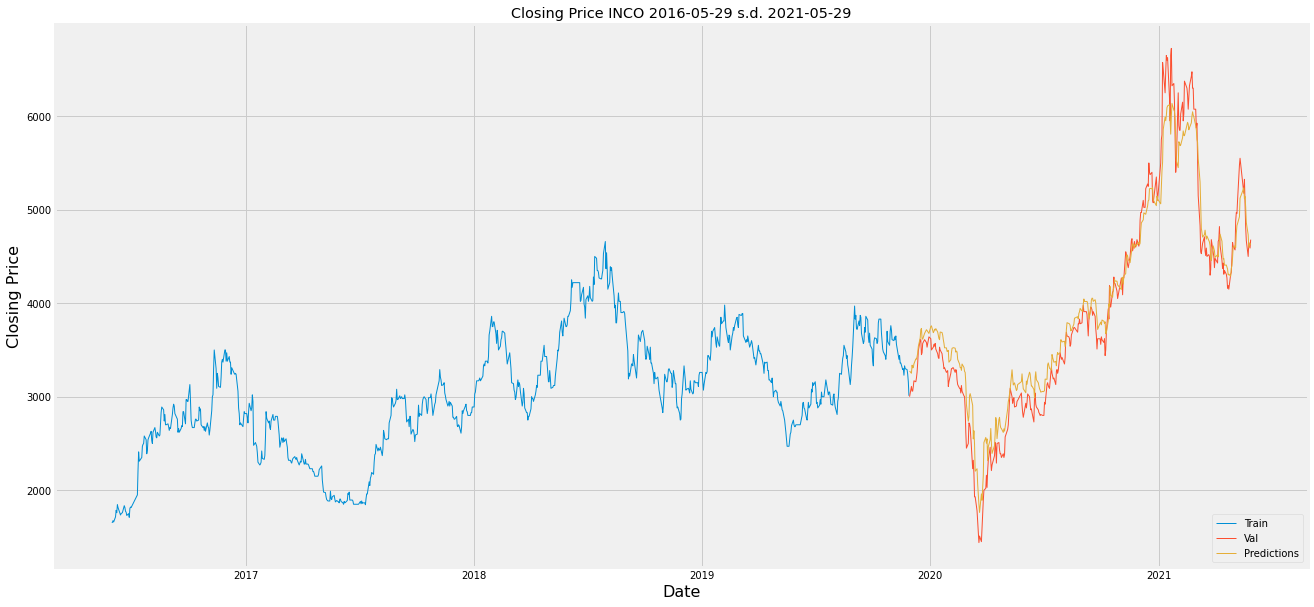

In [21]:
train = data[:data_len-h]
test = data[data_len-h:data_len]
test['Predictions'] = predictions[:,0]
plt.figure(figsize=(20,10))
plt.title(f'Closing Price {stock_code} {startdate} s.d. {enddate}')
plt.xlabel('Date', fontsize = 16 )
plt.ylabel('Closing Price', fontsize = 16 )
plt.plot(train['Close'],linewidth=1)
plt.plot(test[['Close','Predictions']],linewidth=1)
#x = pd.to_datetime('2018/02/01', format='%Y/%m/%d')
#str1 = 'Learning rate: {}'.format(learning_rate)
#str2 = 'Epoch: {}'.format(epoch)
#plt.annotate(str1, (x,4200), (x,4200), fontsize=12)
#plt.annotate(str2, (x,4100), (x,4100), fontsize=12)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

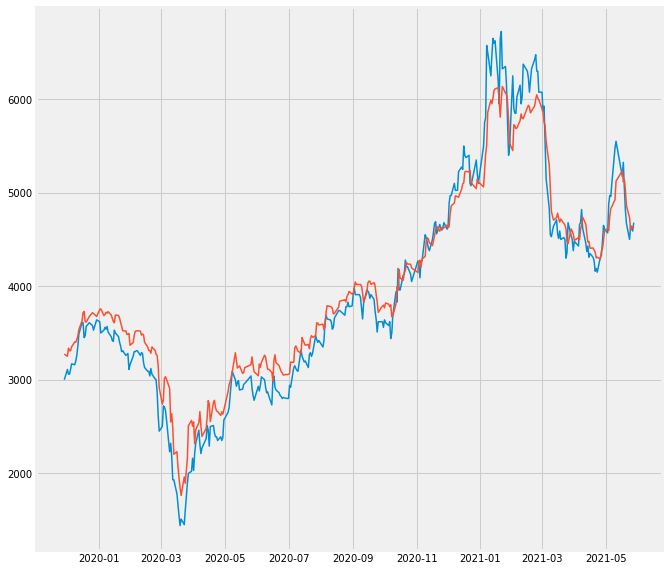

In [20]:
plt.figure(figsize=(10,10))
plt.plot(test[['Close','Predictions']],linewidth=1.5)

Predictions for the days ahead

In [22]:
inp

14

In [23]:
n_days = int(input("Number of days: "))
data_pred = scaled_data[data_len-inp:data_len,:]
for i in range(0,n_days):
  x_pred = np.vstack(data_pred[i:i+inp, :])
  x_pred = np.array(x_pred)
  x_pred = np.reshape(x_pred, (1, x_pred.shape[0], n_feature))
  predict = model.predict(x_pred)
  data_pred = np.vstack((data_pred, predict))

Number of days: 30


[4685.32686472 4714.88493443 4739.84353513 4757.87316382 4767.92074025
 4771.83537632 4762.25842565 4751.71470761 4737.04340637 4723.85769486
 4715.08244604 4706.002267   4700.92776209 4695.21819592 4692.60045826
 4690.99453449 4690.2063781  4689.81103987 4689.43365723 4688.77623022
 4687.64345229 4686.26370609 4684.58911002 4682.81245053 4681.00302994
 4679.1561231  4677.4150598  4675.75621426 4674.2970854  4672.99420178]


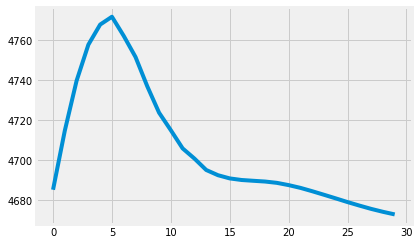

In [24]:
predict_result = data_pred[len(data_pred)-n_days:len(data_pred),:]
predict_result = scaler.inverse_transform(predict_result)
print(predict_result[:,0]) #Hasil prediksi
plt.plot(predict_result[:,0])